In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Métricas y utilidades de scikit-learn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# Modelos
from sklearn.linear_model import LinearRegression, ElasticNetCV, ElasticNet
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

# Para RFE
from sklearn.feature_selection import RFECV

# Para análisis con estadísticos (p-values, summary)
import statsmodels.api as sm

# Para funciones matemáticas
from math import sqrt

# Leer los datos (adaptar la ruta a tu archivo)
data = pd.read_excel("C:/Users/57305/Data science/data_copia1.xlsx")


# 2) Crear columnas lag (ciclo anterior) agrupando por UNIQUEID
data['SOR_lag'] = data.groupby('UNIQUEID')['SOR por ciclo'].shift(1)
data['Np_lag'] = data.groupby('UNIQUEID')['Np por ciclo (total)'].shift(1)
data['PICO_lag'] = data.groupby('UNIQUEID')['PICO DE PRODUCCIÓN'].shift(1)
data['PIR_lag'] = data.groupby('UNIQUEID')['PIR por ciclo'].shift(1)

# 3) Eliminar filas donde los lags sean NaN (el primer ciclo de cada pozo no tendrá datos anteriores)
data = data.dropna(subset=['SOR_lag', 'Np_lag', 'PICO_lag', 'PIR_lag'])

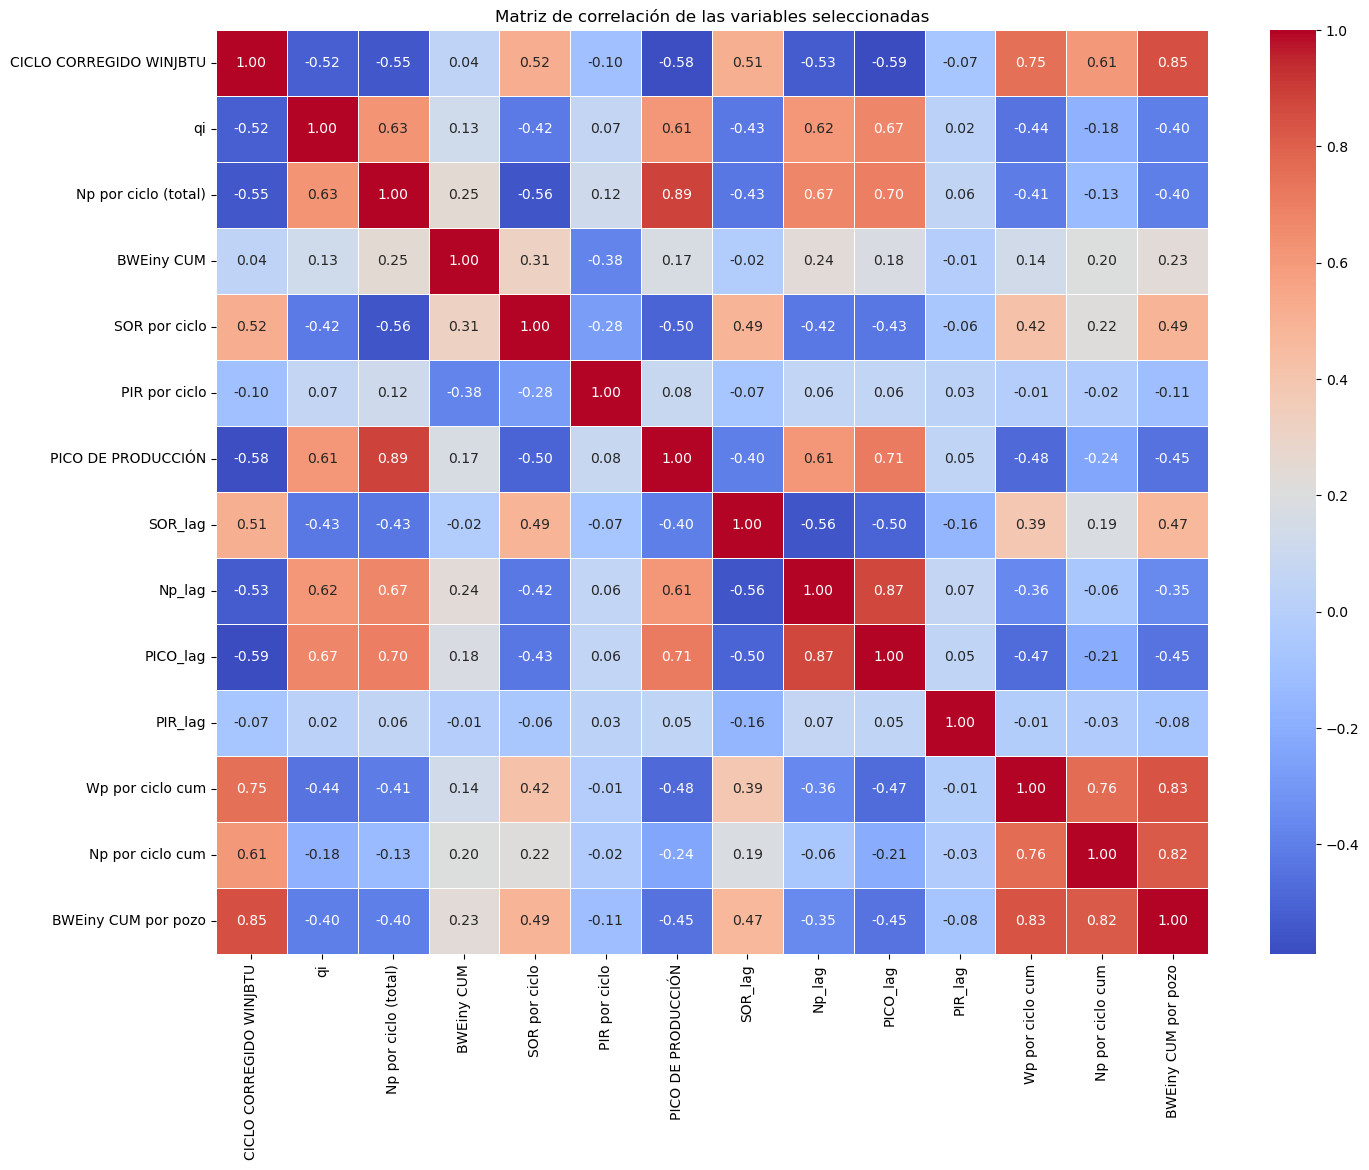

In [24]:
import seaborn as sns

# Asegúrate de que la variable `data` contiene el dataset limpio
target_variables = [
    'CICLO CORREGIDO WINJBTU', 
    'qi', 'Np por ciclo (total)', 
    'BWEiny CUM', 'SOR por ciclo', 'PIR por ciclo', 
    'PICO DE PRODUCCIÓN', 'SOR_lag', 'Np_lag', 'PICO_lag', 'PIR_lag', 
    'Wp por ciclo cum', 'Np por ciclo cum', 'BWEiny CUM por pozo'
]

# Filtrar las columnas de interés
filtered_data = data[target_variables].copy()

# Calcular la matriz de correlación
correlation_matrix = filtered_data.corr()

# Visualización de la matriz de correlación
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de correlación de las variables seleccionadas')
plt.show()


# SECCIÓN 1: CARGAR / DEFINIR LOS DATOS Y COLUMNAS

In [10]:
# Definimos la lista de features recomendadas
features = [
    'CICLO CORREGIDO WINJBTU',
    'BWEiny CUM',
    'qi',
    'SOR_lag',
    'Np_lag',
    'PICO_lag',
    'PIR_lag'
]

# Target a predecir
target = 'Np por ciclo (total)'

# Dividimos en X, y
X = data[features].copy()
y = data[target].copy()

# Partición train/test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Para guardar las predicciones de cada modelo y comparar
prediction = pd.DataFrame()
prediction['Actual'] = y_test.copy()

# SECCIÓN 2: REGRESIÓN LINEAL MÚLTIPLE + RFE + statsmodels

In [11]:
print("\n=== 2) MÚLTIPLE LINEAR REGRESSION + RFE ===")

# 2.1: Entrenamiento con scikit-learn
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Métricas iniciales
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Coefficients (all features):", lr_model.coef_)
print("Intercept:", lr_model.intercept_)
print("MAE:", mae_lr)
print("RMSE:", rmse_lr)
print("R²:", r2_lr)

# 2.2: RFE con cross-validation para seleccionar variables
print("\n--- RFE con RFECV ---")
selector = RFECV(
    estimator=LinearRegression(),
    cv=3,  # 3-fold CV
    scoring='r2'
)
selector.fit(X_train, y_train)

# Cuántas variables se quedaron
print(f"Variables seleccionadas: {np.sum(selector.support_)}")
print(f"Variables descartadas: {X_train.shape[1] - np.sum(selector.support_)}")

# Chequear ranking
for col, sup, rank in zip(X_train.columns, selector.support_, selector.ranking_):
    print(col, " - Seleccionado?" if sup else " - NO", "Rank:", rank)

# 2.3: statsmodels con las variables seleccionadas
X_train_rfe = X_train.loc[:, selector.support_].copy()
X_train_rfe_sm = sm.add_constant(X_train_rfe)  # añadir intercepto

linear_regression_sm = sm.OLS(y_train, X_train_rfe_sm).fit()
print("\n--- Statsmodels Summary (RFE features) ---")
print(linear_regression_sm.summary())

# 2.4: Predecir en test con las variables RFE
X_test_rfe = X_test.loc[:, selector.support_].copy()
X_test_rfe_sm = sm.add_constant(X_test_rfe)

y_pred_lr_rfe = linear_regression_sm.predict(X_test_rfe_sm)

# Métricas
r2_lr_rfe = r2_score(y_test, y_pred_lr_rfe)
mae_lr_rfe = mean_absolute_error(y_test, y_pred_lr_rfe)
rmse_lr_rfe = sqrt(mean_squared_error(y_test, y_pred_lr_rfe))

print("\n>>> MÉTRICAS LR + RFE (TEST) <<<")
print("R²:", r2_lr_rfe)
print("MAE:", mae_lr_rfe)
print("RMSE:", rmse_lr_rfe)

# Guardamos la predicción final de la regresión lineal RFE
prediction['Multiple Linear Regression'] = y_pred_lr_rfe


=== 2) MÚLTIPLE LINEAR REGRESSION + RFE ===
Coefficients (all features): [-2.65602521e+02  1.86362563e-01  5.72747114e+01 -7.14068432e+00
  1.63591741e-01  3.28919484e+01  7.20369224e+00]
Intercept: 3490.3173563566697
MAE: 3185.022702088854
RMSE: 4834.839244817311
R²: 0.5846179437133939

--- RFE con RFECV ---
Variables seleccionadas: 7
Variables descartadas: 0
CICLO CORREGIDO WINJBTU  - Seleccionado? Rank: 1
BWEiny CUM  - Seleccionado? Rank: 1
qi  - Seleccionado? Rank: 1
SOR_lag  - Seleccionado? Rank: 1
Np_lag  - Seleccionado? Rank: 1
PICO_lag  - Seleccionado? Rank: 1
PIR_lag  - Seleccionado? Rank: 1

--- Statsmodels Summary (RFE features) ---
                             OLS Regression Results                             
Dep. Variable:     Np por ciclo (total)   R-squared:                       0.578
Model:                              OLS   Adj. R-squared:                  0.577
Method:                   Least Squares   F-statistic:                     828.6
Date:                  

# SECCIÓN 3: ELASTIC NET (Cross-validation con GridSearchCV)

In [12]:
print("\n=== 3) ELASTIC NET ===")

# 3.1: Definir el modelo base para la búsqueda
cv_model_en = ElasticNetCV()

# 3.2: Hiperparámetros a explorar
param_grid_en = {
    'l1_ratio': [0.1, 0.5, 0.7, 0.9],
    'n_alphas': [10, 50, 100],
    'max_iter': [100, 500, 1000],
    'cv': [3, 6, 10]  # Cross-validation interna del ElasticNetCV
}

# 3.3: GridSearch
grid_search_en = GridSearchCV(
    cv_model_en,
    param_grid_en,
    cv=5,  # CV externo para la búsqueda
    error_score='raise',
    scoring='r2'
)
grid_search_en.fit(X_train, y_train)

best_params_en = grid_search_en.best_params_
best_model_en = grid_search_en.best_estimator_

print("Best Hyperparameters (ElasticNet):", best_params_en)
print("Best Model (ElasticNet):", best_model_en)

# 3.4: Entrenar la mejor combinación final
# (Ya lo hace 'fit', pero si quieres instanciar manualmente:)
elastic_final = ElasticNet(
    l1_ratio=best_model_en.l1_ratio_,
    alpha=best_model_en.alpha_,
    max_iter=best_model_en.max_iter
)
elastic_final.fit(X_train, y_train)

# 3.5: Métricas en test
y_pred_en = elastic_final.predict(X_test)

r2_en = r2_score(y_test, y_pred_en)
mae_en = mean_absolute_error(y_test, y_pred_en)
rmse_en = sqrt(mean_squared_error(y_test, y_pred_en))

print("\n>>> MÉTRICAS ELASTIC NET (TEST) <<<")
print("R²:", r2_en)
print("MAE:", mae_en)
print("RMSE:", rmse_en)

# Guardar predicción
prediction['Elastic Net'] = y_pred_en


=== 3) ELASTIC NET ===
Best Hyperparameters (ElasticNet): {'cv': 3, 'l1_ratio': 0.9, 'max_iter': 100, 'n_alphas': 10}
Best Model (ElasticNet): ElasticNetCV(cv=3, l1_ratio=0.9, max_iter=100, n_alphas=10)

>>> MÉTRICAS ELASTIC NET (TEST) <<<
R²: 0.46664033033229224
MAE: 3532.9721359067057
RMSE: 5478.58317305292


# SECCIÓN 4: RED NEURONAL (MLPRegressor) + GridSearchCV

In [17]:
print("\n=== 4) ARTIFICIAL NEURAL NETWORK (MLPRegressor) ===")

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

nn_regressor_base = Pipeline([
    ("scaler", RobustScaler()),  # menos sensible a outliers
    ("mlp", MLPRegressor(random_state=42))
])

param_grid_nn = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 10), (100, 50, 10)],
    'mlp__activation': ['identity', 'tanh','relu'],  # 'logistic' a veces da problemas con grandes valores
    'mlp__solver': ['lbfgs', 'adam'],  # 'sgd' es más lento
    'mlp__max_iter': [300, 600, 1000]   # Aumentamos iteraciones
}

grid_search_nn = GridSearchCV(
    nn_regressor_base,
    param_grid_nn,
    cv=5,
    scoring='r2',
    error_score='raise',
    verbose=1,
    n_jobs=-1
)

grid_search_nn.fit(X_train, y_train)

best_params_nn = grid_search_nn.best_params_
best_model_nn = grid_search_nn.best_estimator_

print("Best Hyperparameters (Neural Net):", best_params_nn)
print("Best Model (Neural Net):", best_model_nn)

# Predecir en test
y_pred_nn = best_model_nn.predict(X_test)

r2_nn = r2_score(y_test, y_pred_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))

print("\n>>> MÉTRICAS NEURAL NET (TEST) <<<")
print("R²:", r2_nn)
print("MAE:", mae_nn)
print("RMSE:", rmse_nn)

# Guardar predicción
prediction['Artificial Neural Network'] = y_pred_nn


=== 4) ARTIFICIAL NEURAL NETWORK (MLPRegressor) ===
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Hyperparameters (Neural Net): {'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (50, 10), 'mlp__max_iter': 300, 'mlp__solver': 'lbfgs'}
Best Model (Neural Net): Pipeline(steps=[('scaler', RobustScaler()),
                ('mlp',
                 MLPRegressor(hidden_layer_sizes=(50, 10), max_iter=300,
                              random_state=42, solver='lbfgs'))])

>>> MÉTRICAS NEURAL NET (TEST) <<<
R²: 0.6243743172934635
MAE: 3048.7333428003903
RMSE: 4597.648993103088


C:\Users\57305\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


# SECCIÓN 5: RANDOM FOREST (RandomizedSearchCV)

In [15]:
print("\n=== 5) RANDOM FOREST ===")

rf = RandomForestRegressor(random_state=42)

# Definir hiperparámetros a explorar
param_dist_rf = {
    'n_estimators': np.arange(50, 400, 50),
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

random_search_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_dist_rf,
    n_iter=10,
    cv=3,
    random_state=42,
    scoring='r2'
)
random_search_rf.fit(X_train, y_train)

best_params_rf = random_search_rf.best_params_
best_model_rf = random_search_rf.best_estimator_

print("Best Hyperparameters (Random Forest):", best_params_rf)
print("Best Model (Random Forest):", best_model_rf)

# Entrenar final
rf_final = RandomForestRegressor(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    random_state=42
)
rf_final.fit(X_train, y_train)

y_pred_rf = rf_final.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))

print("\n>>> MÉTRICAS RANDOM FOREST (TEST) <<<")
print("R²:", r2_rf)
print("MAE:", mae_rf)
print("RMSE:", rmse_rf)

# Guardar predicción
prediction['Random Forest Regressor'] = y_pred_rf


=== 5) RANDOM FOREST ===
Best Hyperparameters (Random Forest): {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 10}
Best Model (Random Forest): RandomForestRegressor(max_depth=10, n_estimators=300, random_state=42)

>>> MÉTRICAS RANDOM FOREST (TEST) <<<
R²: 0.620581962902093
MAE: 3059.7263264903086
RMSE: 4620.799868073502


# SECCIÓN 6: COMPARAR Y GRAFICAR


--- COMPARACIÓN DE MÉTRICAS ---

                   R2      MAE     RMSE
LinearReg (RFE)  0.58  3185.02  4834.84
ElasticNet       0.47  3532.97  5478.58
NeuralNet        0.63  3048.67  4586.80
RandomForest     0.62  3059.73  4620.80


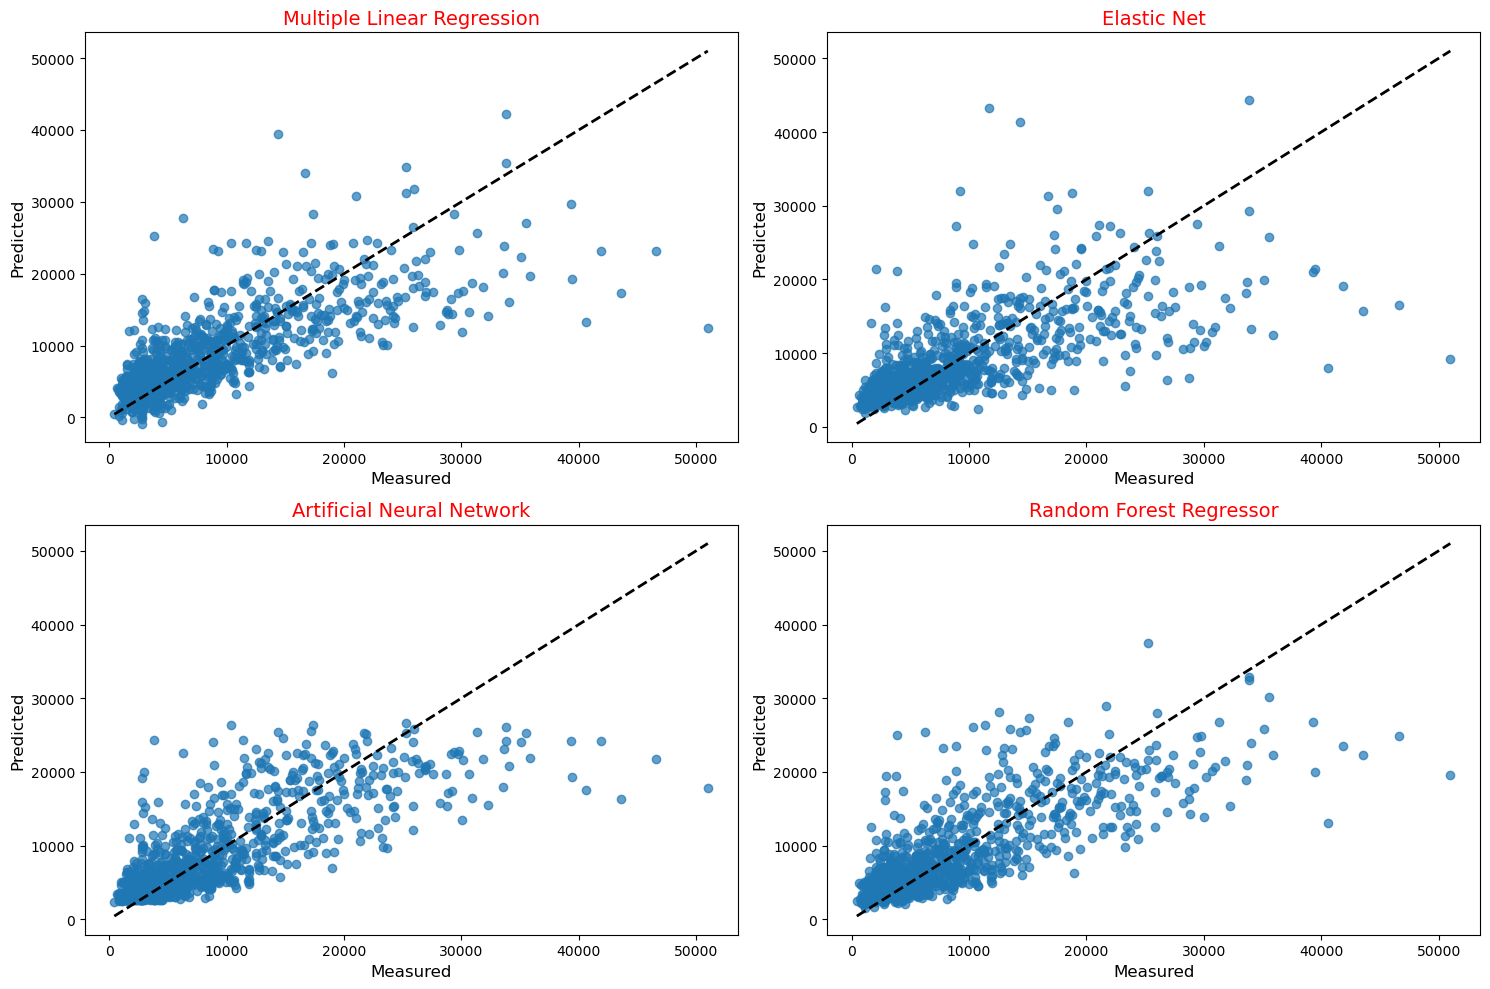

In [16]:
print("\n--- COMPARACIÓN DE MÉTRICAS ---\n")
comparison = pd.DataFrame({
    'R2': [round(r2_lr_rfe,2), round(r2_en,2), round(r2_nn,2), round(r2_rf,2)],
    'MAE': [round(mae_lr_rfe,2), round(mae_en,2), round(mae_nn,2), round(mae_rf,2)],
    'RMSE': [round(rmse_lr_rfe,2), round(rmse_en,2), round(rmse_nn,2), round(rmse_rf,2)]
}, index=['LinearReg (RFE)', 'ElasticNet', 'NeuralNet', 'RandomForest'])

print(comparison)

# Visualizar real vs predicho para cada modelo
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

model_names = ['Multiple Linear Regression', 'Elastic Net', 'Artificial Neural Network', 'Random Forest Regressor']
axes = axes.flatten()

for i, ax in enumerate(axes):
    x_vals = prediction['Actual']
    y_vals = prediction[model_names[i]]
    ax.scatter(x_vals, y_vals, alpha=0.7)
    ax.plot([x_vals.min(), x_vals.max()], [x_vals.min(), x_vals.max()], 'k--', lw=2)
    ax.set_xlabel('Measured', fontsize=12)
    ax.set_ylabel('Predicted', fontsize=12)
    ax.set_title(model_names[i], color='red', fontsize=14)

plt.tight_layout()
plt.show()

In [18]:
import pandas as pd
import numpy as np

def evaluar_inyeccion_nuevo_pozo(
    pozo_sor_anterior,
    pozo_pico_anterior,
    pozo_vapor_anterior,
    pozo_qi_anterior,
    vapor_inyectado,
    ciclo_actual,
    model_np,       # Modelo entrenado (por ejemplo, MLPRegressor) SOLO para predecir Np
    data
):
    """
    Evalúa si es "bueno" realizar la inyección de vapor para un nuevo pozo en el ciclo dado.
    Solo se predice Np usando 'model_np'. 
    Se comparan valores históricos y se toma una decisión básica (buena/mala).
    """
    # 1) Calcular promedios históricos del ciclo_actual para comparar
    promedio_sor_historico  = data[data['CICLO CORREGIDO WINJBTU'] == ciclo_actual]['SOR por ciclo'].mean()
    promedio_np_historico   = data[data['CICLO CORREGIDO WINJBTU'] == ciclo_actual]['Np por ciclo (total)'].mean()
    promedio_pico_historico = data[data['CICLO CORREGIDO WINJBTU'] == ciclo_actual]['PICO DE PRODUCCIÓN'].mean()
    promedio_pir_historico  = data[data['CICLO CORREGIDO WINJBTU'] == ciclo_actual]['PIR por ciclo'].mean()

    # 2) Crear un DataFrame con la "nueva instancia" de features
    #    Ajusta a las columnas que tu modelo_np espera:
    #    (Ejemplo: 'CICLO CORREGIDO WINJBTU', 'BWEiny CUM', 'qi', 'SOR_lag', 'Np_lag', 'PICO_lag', 'PIR_lag', etc.)
    nueva_instancia = pd.DataFrame(
        [[
            ciclo_actual,
            vapor_inyectado,
            pozo_qi_anterior,
            pozo_sor_anterior,
            pozo_vapor_anterior,
            pozo_pico_anterior
        ]],
        columns=[
            'CICLO CORREGIDO WINJBTU',
            'BWEiny CUM',
            'qi',
            'SOR_lag',
            'Np_lag',        # o 'vapor_anterior' si lo usas como Np_lag, etc.
            'PICO_lag'
        ]
    )

    # 3) Predecir Np con el modelo (pipeline o modelo directo)
    #    Si tienes un pipeline con escalado/transformaciones, asegúrate
    #    de usar: np_predicho = model_np.predict(nueva_instancia_transf)
    #    Aquí, para simplicidad, llamamos directo:
    np_predicho = model_np.predict(nueva_instancia)[0]

    # 4) Calcular SOR "calculado" (vapor_inyectado / np_predicho), si lo consideras
    if np_predicho != 0:
        sor_calculado = vapor_inyectado / np_predicho
    else:
        sor_calculado = np.inf

    # 5) Criterios de decisión (ejemplo): 
    #    - Requerir que el SOR calculado sea < promedio_sor_historico
    #      (o < un valor fijo) y la producción predicha > promedio_np_historico
    es_eficiente       = (sor_calculado < promedio_sor_historico) if not np.isnan(promedio_sor_historico) else False
    es_produccion_alta = (np_predicho > promedio_np_historico)   if not np.isnan(promedio_np_historico)  else False

    if es_eficiente and es_produccion_alta:
        decision = "Buena decisión de inyectar"
    else:
        decision = "Podría no ser óptimo"

    # 6) Construir mensaje final
    output = f"""
Valores del pozo anterior:
- SOR Anterior: {pozo_sor_anterior}
- Pico de Producción Anterior: {pozo_pico_anterior}
- Vapor Inyectado Anterior: {pozo_vapor_anterior}
- qi Anterior: {pozo_qi_anterior}
**************************************************
Predicción para el nuevo ciclo (ciclo {ciclo_actual}):
- NP Predicho: {np_predicho:.2f}
- SOR Calculado: {sor_calculado:.2f}
**************************************************
Valores históricos para el ciclo {ciclo_actual}:
- SOR Histórico (Prom.): {promedio_sor_historico:.2f}
- NP Histórico (Prom.):  {promedio_np_historico:.2f}
- Pico Hist. (Prom.):    {promedio_pico_historico:.2f}
- PIR Hist. (Prom.):     {promedio_pir_historico:.2f}
**************************************************
Decisión: {decision}
    """
    return output


In [22]:
# ================================
# EJEMPLO DE USO DEL MODELO AJUSTADO
# ================================

# Supongamos que estos valores provienen del ciclo anterior de tu pozo
nuevo_pozo_sor_anterior = 0.93   # SOR del ciclo anterior
nuevo_pozo_pico_anterior = 48.65 # Pico de producción del ciclo anterior
nuevo_pozo_vapor_anterior = 5656 # Vapor inyectado del ciclo anterior
nuevo_pozo_qi_anterior = 50.9    # qi (caudal inicial) del ciclo anterior

# Definimos la cantidad de vapor planeada y el ciclo nuevo
vapor_inyectado_nuevo = 5656
ciclo_nuevo = 6

# Llamada a la función para evaluar inyección
resultado_evaluacion = evaluar_inyeccion_nuevo_pozo(
    pozo_sor_anterior      = nuevo_pozo_sor_anterior,
    pozo_pico_anterior     = nuevo_pozo_pico_anterior,
    pozo_vapor_anterior    = nuevo_pozo_vapor_anterior,
    pozo_qi_anterior       = nuevo_pozo_qi_anterior,
    vapor_inyectado        = vapor_inyectado_nuevo,
    ciclo_actual           = ciclo_nuevo,
    model_np               = y_pred_nn,  # Tu modelo entrenado (p. ej. RandomForest)
    data                   = data       # Tu DataFrame histórico
)

# Mostrar resultados en pantalla
print(resultado_evaluacion)


AttributeError: 'numpy.ndarray' object has no attribute 'predict'